In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

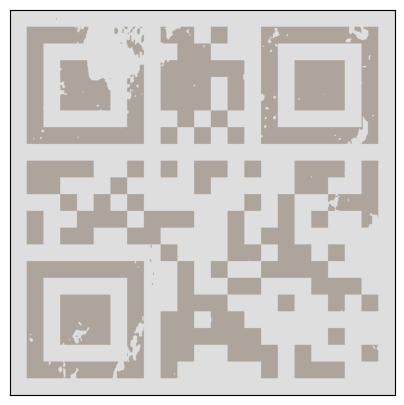

In [15]:
img = cv2.imread("08-Compresso-Espresso.png")

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#adaptive_threshold = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
_, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

kernel = np.ones((3, 3), np.uint8)
#dilated_img = cv2.dilate(binary_img, kernel, iterations=1)
#opening = cv2.morphologyEx(_, cv2.MORPH_OPEN, kernel)


fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img, cmap='gray');

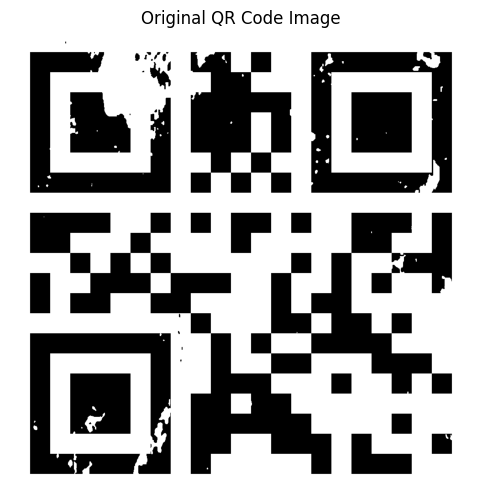

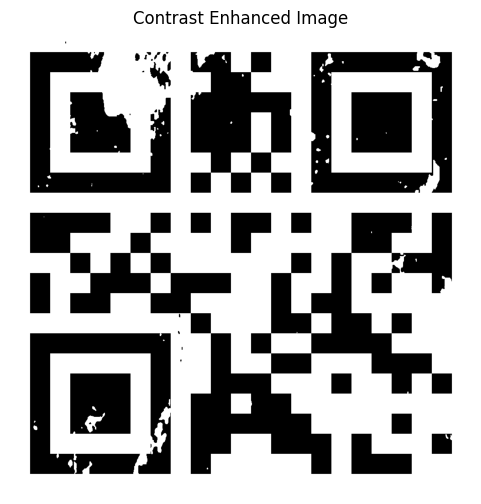

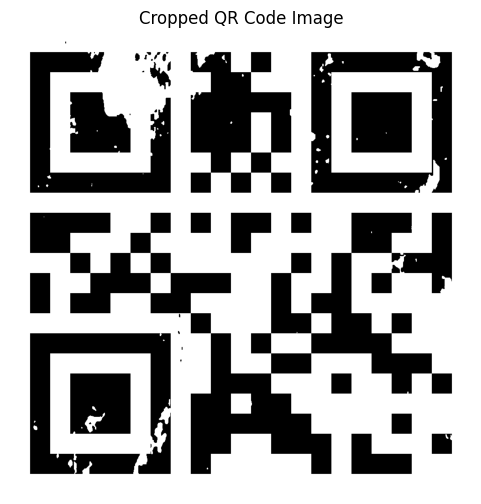

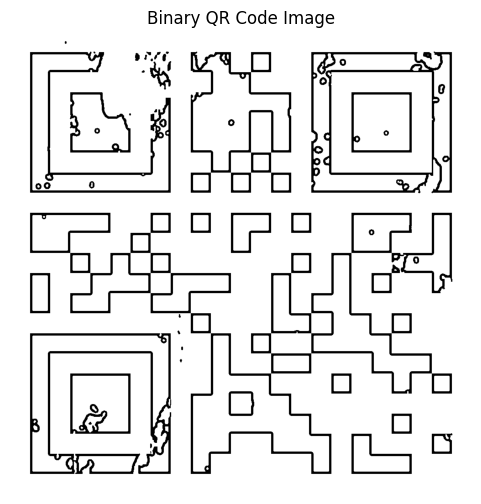

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(img, title="Image", cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the QR code image
image_path = "08-Compresso-Espresso.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the original QR code image
plot_image(image, "Original QR Code Image")

# Enhance contrast using histogram equalization
equalized_image = cv2.equalizeHist(image)
plot_image(equalized_image, "Contrast Enhanced Image")

#Detect contours
contours, _ = cv2.findContours(equalized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize min/max coordinates
min_x, min_y = np.inf, np.inf
max_x, max_y = -np.inf, -np.inf

# Update coordinates based on contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if cv2.contourArea(contour) > 100:
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)

expand_pixels = 10  # Number of pixels to expand around the detected QR code
min_x = max(min_x - expand_pixels, 0)
min_y = max(min_y - expand_pixels, 0)
max_x = min(max_x + expand_pixels, image.shape[1])
max_y = min(max_y + expand_pixels, image.shape[0])

# Crop to the minimum bounding box around all contours
cropped_image = equalized_image[min_y:max_y, min_x:max_x]

plot_image(cropped_image, "Cropped QR Code Image")

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Apply adaptive thresholding to create a binary image
binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
plot_image(binary_image, "Binary QR Code Image")


# # Apply a Laplacian filter to enhance edges
# laplacian = cv2.Laplacian(binary_image, cv2.CV_64F)

# # Convert Laplacian to the same type as binary_image before subtraction
# laplacian_converted = np.clip(laplacian, 0, 255).astype(np.uint8)

# # Subtract to enhance edges
# sharpened_image = cv2.subtract(binary_image, laplacian_converted)
# plot_image(sharpened_image, "Sharpened QR Code Image")

In [17]:
img = cv2.imread("08-Compresso-Espresso.png", cv2.IMREAD_GRAYSCALE)

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    if (row != 255).any():
        start_row = row_index
        break

for row_index, row in enumerate(img[::-1]):
    if (row != 255).any():
        end_row = img.shape[0] - row_index
        break

for col_index, col in enumerate(cv2.transpose(img)):
    if (col != 255).any():
        start_col = col_index
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    if (col != 255).any():
        end_col = img.shape[1] - col_index
        break

img_no_quiet_zone = img[start_row:end_row, start_col:end_col]

img_21x21_grid = cv2.resize(img_no_quiet_zone, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

# fig = plt.figure(figsize=(3, 3));
# plt.xticks([], []);
# plt.yticks([], []);
# plt.imshow(img_21x21_grid, cmap='gray');
print(img_21x21_grid.shape)

(21, 21)


In [18]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [19]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [20]:
img_21x21_grid_inv = 1 - img_21x21_grid
ecl = img_21x21_grid_inv[8, 0:2]
mask = img_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [1 1]
MASK = [1 1 1]
ENC = [1, 1, 1, 1]
LEN = [1, 1, 1, 1, 1, 1, 1, 1] = 255 data symbols, each consisting of 8 bits


In [21]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [22]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)

byte_index = 0
while byte_index < len(block_starting_indices) and byte_index < len_int:
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1


if byte_index < len(block_starting_indices):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
    byte_index += 1


while byte_index < len(block_starting_indices) and byte_index < 25 - len_int:
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

    

start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1

for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

11111111 (=255) = ÿ
11110101 (=245) = õ
01010101 (=085) = U
01010101 (=085) = U
01011010 (=090) = Z
10101010 (=170) = ª
10101010 (=170) = ª
10101111 (=175) = ¯
11111111 (=255) = ÿ
11111111 (=255) = ÿ
11110101 (=245) = õ
01010101 (=085) = U
01010101 (=085) = U
01010101 (=085) = U
01010101 (=085) = U
01011010 (=090) = Z
10101010 (=170) = ª
1010 (=010) = 

10101010 (=170) = ª
10101010 (=170) = ª
10101010 (=170) = ª
11111111 (=255) = ÿ
11111111 (=255) = ÿ
01010101 (=085) = U
10101010 (=170) = ª


IndexError: list index out of range